In [ ]:
#hide
#skip
! [ -e /content ] && pip install -Uqq fastai  # upgrade fastai on colab

In [ ]:
#export
import tempfile
from fastai.basics import *

In [ ]:
#hide
from nbdev.showdoc import *

In [ ]:
#all_slow

In [ ]:
#default_exp callback.captum

# Captum
Captum is the Model Interpretation Library from PyTorch as available [here](https://captum.ai)

To use this we need to install the package using 

`conda install captum -c pytorch`

or 

`pip install captum`

This is a Call back to use Captum.

In [ ]:
# export
from ipykernel import jsonutil

In [ ]:
# export
# Dirty hack as json_clean doesn't support CategoryMap type
_json_clean=jsonutil.json_clean
def json_clean(o):
    o = list(o.items) if isinstance(o,CategoryMap) else o
    return _json_clean(o)

jsonutil.json_clean = json_clean

In [ ]:
#export
from captum.attr import IntegratedGradients,NoiseTunnel,GradientShap,Occlusion
from captum.attr import visualization as viz

from matplotlib.colors import LinearSegmentedColormap

from captum.insights import AttributionVisualizer, Batch
from captum.insights.features import ImageFeature

In all this notebook, we will use the following data:

In [ ]:
from fastai.vision.all import *

In [ ]:
path = untar_data(URLs.PETS)/'images'
fnames = get_image_files(path)
def is_cat(x): return x[0].isupper()
dls = ImageDataLoaders.from_name_func(
    path, fnames, valid_pct=0.2, seed=42,
    label_func=is_cat, item_tfms=Resize(128))

In [ ]:
from random import randint

In [ ]:
learn = cnn_learner(dls, resnet34, metrics=error_rate)
learn.fine_tune(1)

epoch,train_loss,valid_loss,error_rate,time
0,0.367540,0.159957,0.060217,00:10


epoch,train_loss,valid_loss,error_rate,time
0,0.144134,0.073435,0.027064,00:12


# Captum Interpretation

The Distill Article [here](https://distill.pub/2020/attribution-baselines/) provides a good overview of what baseline image to choose. We can try them one by one.

In [ ]:
#export
class CaptumInterpretation():
    "Captum Interpretation for Resnet"
    def __init__(self,learn,cmap_name='custom blue',colors=None,N=256,methods=['original_image','heat_map'],signs=["all", "positive"],outlier_perc=1):
        store_attr('learn,cmap_name,colors,N,methods,signs,outlier_perc')
        self.colors = [(0, '#ffffff'),(0.25, '#000000'),(1, '#000000')] if self.colors is None else self.colors
        self.dls=learn.dls
        self.model=self.learn.model
        self.supported_metrics=['IG','NT','Occl']


    def get_baseline_img(self, img_tensor,baseline_type):
        baseline_img=None
        if baseline_type=='zeros': baseline_img= img_tensor*0
        if baseline_type=='uniform': baseline_img= torch.rand(img_tensor.shape)
        if baseline_type=='gauss':
            baseline_img= (torch.rand(img_tensor.shape).to(self.dls.device)+img_tensor)/2
        return baseline_img.to(self.dls.device)

    def visualize(self,inp,metric='IG',n_steps=1000,baseline_type='zeros',nt_type='smoothgrad',strides = (3, 4, 4), sliding_window_shapes=(3,15, 15)):
        if metric not in self.supported_metrics:
            raise Exception(f"Metric {metric} is not supported. Currently {self.supported_metrics} are only supported")
        tls = L([TfmdLists(inp, t) for t in L(ifnone(self.dls.tfms,[None]))])
        inp_data=list(zip(*(tls[0],tls[1])))[0]

        # Get Data
        enc_data,dec_data=self._get_enc_dec_data(inp_data)

        # Get Required Metrics
        attributions=self._get_attributions(enc_data,metric,n_steps,nt_type,baseline_type,strides,sliding_window_shapes)

        #Visualise the attributions
        self._viz(attributions,dec_data,metric)

    def _viz(self,attributions,dec_data,metric):
        default_cmap = LinearSegmentedColormap.from_list(self.cmap_name,self.colors, N=self.N)
        _ = viz.visualize_image_attr_multiple(np.transpose(attributions.squeeze().cpu().detach().numpy(), (1,2,0)),
                                              np.transpose(dec_data[0].numpy(), (1,2,0)),
                                              methods=self.methods,
                                              cmap=default_cmap,
                                              show_colorbar=True,
                                              signs=self.signs,
                                              outlier_perc=self.outlier_perc, titles=[f'Original Image - ({dec_data[1]})', metric])



    def _get_enc_dec_data(self,inp_data):
        dec_data=self.dls.after_item(inp_data)
        enc_data=dls.after_batch(to_device(self.dls.before_batch(dec_data),self.dls.device))
        return(enc_data,dec_data)


    def _get_attributions(self,enc_data,metric,n_steps,nt_type,baseline_type,strides,sliding_window_shapes):
        # Get Baseline
        baseline=self.get_baseline_img(enc_data[0],baseline_type)
        supported_metrics ={}
        if metric == 'IG':
            self._integrated_gradients = self._integrated_gradients if hasattr(self,'_integrated_gradients') else IntegratedGradients(self.model)
            return self._integrated_gradients.attribute(enc_data[0],baseline, target=enc_data[1], n_steps=200)
        elif metric == 'NT':
            self._integrated_gradients = self._integrated_gradients if hasattr(self,'_integrated_gradients') else IntegratedGradients(self.model)
            self._noise_tunnel= self._noise_tunnel if hasattr(self,'_noise_tunnel') else NoiseTunnel(self._integrated_gradients)
            return self._noise_tunnel.attribute(enc_data[0].to(self.dls.device), n_samples=1, nt_type=nt_type, target=enc_data[1])
        elif metric == 'Occl':
            self._occlusion = self._occlusion if hasattr(self,'_occlusion') else Occlusion(self.model)
            return self._occlusion.attribute(enc_data[0].to(self.dls.device),
                                       strides = strides,
                                       target=enc_data[1],
                                       sliding_window_shapes=sliding_window_shapes,
                                       baselines=baseline)

## Interpretation

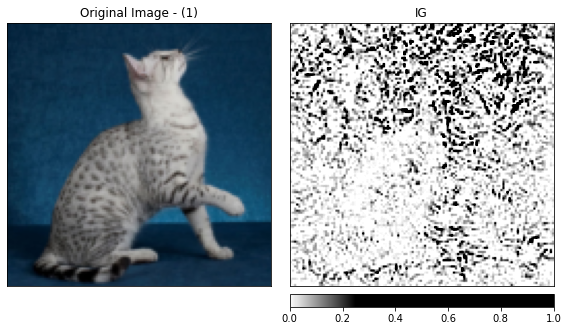

In [ ]:
captum=CaptumInterpretation(learn)
idx=randint(0,len(fnames))
captum.visualize(fnames[idx])

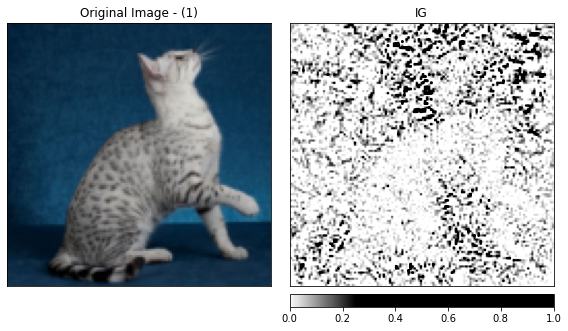

In [ ]:
captum.visualize(fnames[idx],baseline_type='uniform')

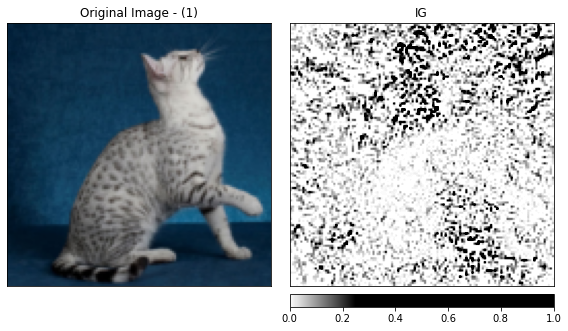

In [ ]:
captum.visualize(fnames[idx],baseline_type='gauss')

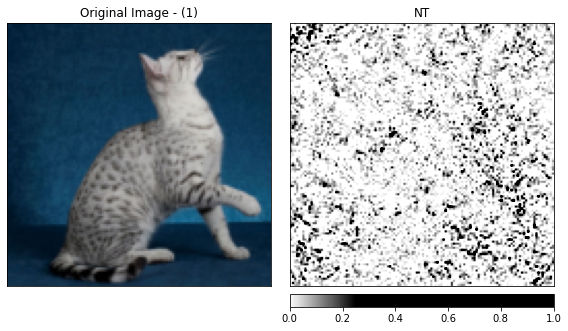

In [ ]:
captum.visualize(fnames[idx],metric='NT',baseline_type='uniform')

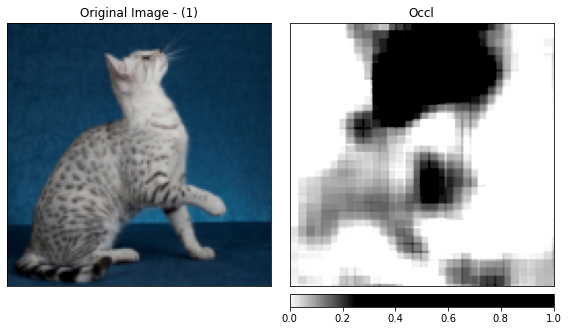

In [ ]:
captum.visualize(fnames[idx],metric='Occl',baseline_type='gauss')

## Captum Insights Callback

In [ ]:
@patch
def _formatted_data_iter(x: CaptumInterpretation,dl,normalize_func):
    dl_iter=iter(dl)
    while True:
        images,labels=next(dl_iter)
        images=normalize_func.decode(images).to(dl.device)
        yield Batch(inputs=images, labels=labels)

In [ ]:
#export
@patch
def insights(x: CaptumInterpretation,inp_data,debug=True):
    _baseline_func= lambda o: o*0
    _get_vocab = lambda vocab: list(map(str,vocab)) if isinstance(vocab[0],bool) else vocab
    dl = x.dls.test_dl(L(inp_data),with_labels=True, bs=4)
    normalize_func= next((func for func in dl.after_batch if type(func)==Normalize),noop)

    visualizer = AttributionVisualizer(
        models=[x.model],
        score_func=lambda o: torch.nn.functional.softmax(o, 1),
        classes=_get_vocab(dl.vocab),
        features=[
            ImageFeature(
                "Image",
                baseline_transforms=[_baseline_func],
                input_transforms=[normalize_func],
            )
        ],
        dataset=x._formatted_data_iter(dl,normalize_func)
    )
    visualizer.render(debug=debug)

In [ ]:
captum=CaptumInterpretation(learn)
captum.insights(fnames)

Captum Insights widget created.


CaptumInsights(insights_config={'classes': ['False', 'True'], 'methods': ['Deconvolution', 'Deep Lift', 'Guide…

Output()